# **Dataset Preparation:**

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from pathlib import Path

dataset_path = Path('/content/drive/My Drive/Traffic Signs Dataset')
dataset_train_path = dataset_path / 'Train'

In [13]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class OwnDataset(Dataset):
    def __init__(self, root_dir: str, transform: transforms.Compose = None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith(('.png'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image[:3, :, :]  # ignore alpha channel


image_target_size = (64, 64)
transform = transforms.Compose([
    transforms.ColorJitter(brightness=[0.9, 1.1]),
    transforms.RandomRotation(10),
    transforms.Resize(image_target_size),
    transforms.ToTensor()
])

train_dataset = OwnDataset(root_dir='/content/drive/My Drive/GAN-Dataset', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# **GAN:**

In [5]:
!pip install pytorch_lightning

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

## **Generator:**

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl


class Generator(pl.LightningModule):
    def __init__(self, z_dim: int):
        super(Generator, self).__init__()
        self.genenerator = nn.Sequential(
            nn.ConvTranspose2d(in_channels=z_dim, out_channels=1024, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.generator(x)

## **Discriminator:**

In [24]:
class Discriminator(pl.LightningModule):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),

            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.discriminator(x)

## **GAN:**

In [25]:
class GAN(pl.LightningModule):
    def __init__(self, z_dim: int = 128):
        super(GAN, self).__init__()
        self.generator = Generator(z_dim)
        self.discriminator = Discriminator()
        self.z_dim = z_dim
        self.generator_optimizer = torch.optim.Adam(self.generator.parameters(), lr=5e-5)
        self.discriminator_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=1e-5)

        self.step_metrics = {"gen_loss": [], "disc_loss": []}
        self.metrics = {"gen_loss": [], "disc_loss": []}

        self.automatic_optimization = False


    def forward(self, z):
        return self.generator(z)

    def generator_step(self, fake_images):
        self.generator_optimizer.zero_grad()
        disc_fake_pred = self.discriminator(fake_images)
        gen_loss = nn.BCELoss()(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        self.generator_optimizer.step()
        return gen_loss

    def discriminator_step(self, real_images, fake_images):
        self.discriminator_optimizer.zero_grad()
        disc_real_pred = self.discriminator(real_images)
        disc_fake_pred = self.discriminator(fake_images.detach())
        real_loss = nn.BCELoss()(disc_real_pred, torch.ones_like(disc_real_pred))
        fake_loss = nn.BCELoss()(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_loss = (real_loss + fake_loss) / 2
        disc_loss.backward()
        self.discriminator_optimizer.step()
        return disc_loss

    def training_step(self, batch, batch_idx):
        real_images = batch
        z = torch.randn(batch.size(0), self.z_dim, 1, 1)
        fake_images = self.generator(z)

        disc_loss = self.discriminator_step(real_images, fake_images)
        self.log('disc_loss', disc_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.step_metrics["disc_loss"].append(disc_loss.item())

        gen_loss = self.generator_step(fake_images)
        self.log('gen_loss', gen_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.step_metrics["gen_loss"].append(gen_loss.item())

        return gen_loss

    def configure_optimizers(self):
        return [self.generator_optimizer, self.discriminator_optimizer], []

    def on_train_epoch_end(self):
        for key, values in self.step_metrics.items():
            self.metrics[key].append(torch.mean(torch.tensor(values)).item())
            self.step_metrics[key] = []

gan = GAN()

# **Training:**

In [26]:
trainer = pl.Trainer(max_epochs=400, callbacks=[], log_every_n_steps=1)
trainer.fit(gan, train_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 13.1 M | train
1 | discriminator | Discriminator | 2.8 M  | train
--------------------------------------------------------
15.9 M    Trainable params
0         Non-trainable params
15.9 M    Total params
63.535    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


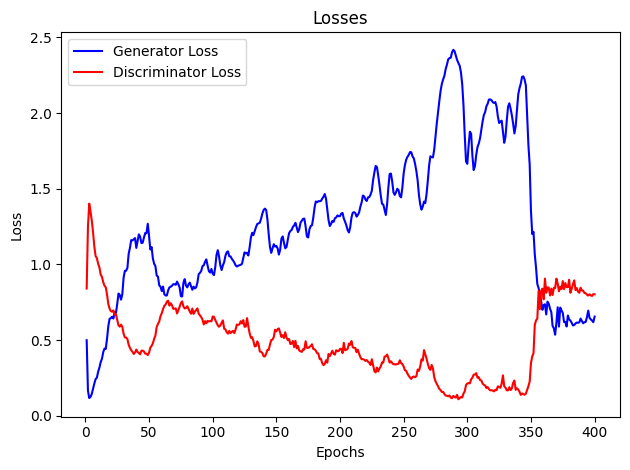

In [29]:
import matplotlib.pyplot as plt

gen_loss = gan.metrics['gen_loss']
disc_loss = gan.metrics['disc_loss']
epochs = range(1, len(gen_loss) + 1)

plt.plot(epochs, gen_loss, 'b-', label='Generator Loss')
plt.plot(epochs, disc_loss, 'r-', label='Discriminator Loss')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# **Generation Test:**

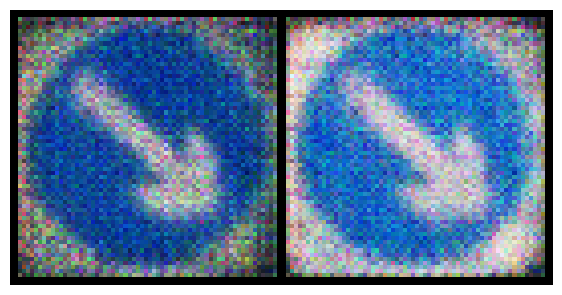

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

def generate_and_display_images(num_images: int = 2):
    gan.generator.eval()
    with torch.no_grad():
        z = torch.randn(num_images, 128, 1, 1)
        fake_images = gan.generator(z)
        grid_img = make_grid(fake_images, nrow=2, normalize=True, scale_each=True)
        np_img = grid_img.cpu().numpy()
        plt.figure(figsize=(7, 7))
        plt.imshow(np.transpose(np_img, (1, 2, 0)))
        plt.axis('off')
        plt.show()

generate_and_display_images()